In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("E:/2cents_/merged_finnifty.csv")

C:\Users\risha\AppData\Local\Temp\ipykernel_8028\1106486740.py:5: DtypeWarning: Columns (4,5,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("E:/2cents_/merged_finnifty.csv")


In [11]:
data = data.head(100000)

In [12]:
pd.set_option('display.max_columns', None)


In [13]:
data = data[data['instrument_type'] == 'CE']

In [60]:
import pandas as pd
import zipfile
from tqdm import tqdm

# Path to the ZIP file
zip_file_path = r"E:\2cents_\Dataset_Provided\NewFolder\Nifty.zip"

# Initialize an empty list to hold DataFrames
dfs = []

# Use zipfile to open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Get a list of all CSV files in the specified folder inside the ZIP
    csv_files = [file for file in zip_ref.namelist() if file.startswith('Options/Nifty/') and file.endswith('.csv')]
    
    # Use tqdm to create a progress bar while reading files
    for file_name in tqdm(csv_files, desc="Reading CSV files"):
        with zip_ref.open(file_name) as file:  # Open the CSV file in the ZIP
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file)
            print(df.shape)
            # Append the DataFrame to the list
            dfs.append(df)

# Merge all DataFrames into one
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a CSV file
output_path = "merged_nifty.csv"
merged_df.to_csv(output_path, index=False)

print(f"Merged nifty CSV saved to {output_path}")


Reading CSV files:   0%|          | 0/54503 [00:00<?, ?it/s]


ParserError: Error tokenizing data. C error: Expected 15 fields in line 112146, saw 25


In [15]:
# Filter data for both scenarios at expiry
# Scenario 1: Find data points where short call has 0 days left (short call expiry)
scenario1_expiry = data[(data['Time_to_expiry'] == 60) | (data['Time_to_expiry'] == 70)]

# Separate short call and long call data at expiry
scenario1_short_expiry = scenario1_expiry[scenario1_expiry['Time_to_expiry'] == 60]
scenario1_long_remaining = scenario1_expiry[scenario1_expiry['Time_to_expiry'] == 70]

# Merge by datetime to align short and long call at expiry
scenario1 = pd.merge(scenario1_short_expiry, scenario1_long_remaining, on='date', suffixes=('_short', '_long'))



# Step 2: Calculate Expiry Payoff for Calendar Spread
# Payoff is calculated as the difference in intrinsic values at expiry
def calculate_intrinsic_value(row, strike_column, spot_price_column):
    return max(row[spot_price_column] - row[strike_column], 0)

# Add a strike price column for clarity (assuming strike price columns are available as 'strike_price_short'/'strike_price_long')
# If not available, you may need to provide specific strike prices or extract it based on option ticker

# Calculate intrinsic values at expiry
scenario1['Intrinsic_Value_Short'] = scenario1.apply(lambda row: calculate_intrinsic_value(row, 'strike_price_short', 'spot_price_short'), axis=1)
scenario1['Intrinsic_Value_Long'] = scenario1.apply(lambda row: calculate_intrinsic_value(row, 'strike_price_long', 'spot_price_long'), axis=1)



# Calendar Spread Payoff at expiry (difference in intrinsic values of long and short)
scenario1['Calendar_Spread_Payoff'] = scenario1['Intrinsic_Value_Long'] - scenario1['Intrinsic_Value_Short']

# Step 3: Display the calculated payoffs
print("Scenario 1 Calendar Spread Payoff at Expiry")
print(scenario1[['date', 'Intrinsic_Value_Short', 'Intrinsic_Value_Long', 'Calendar_Spread_Payoff']].head())

Scenario 1 Calendar Spread Payoff at Expiry
Empty DataFrame
Columns: [date, Intrinsic_Value_Short, Intrinsic_Value_Long, Calendar_Spread_Payoff]
Index: []


In [37]:
tickers = scenario2['ticker_short']

In [38]:
tickers = pd.DataFrame(tickers)

In [41]:
tickers.rename(columns={'ticker_short': 'ticker'}, inplace=True)


In [56]:
import pandas as pd

# Assuming tickers and scenario2_expiry DataFrames already exist

# Step 1: Ensure both columns are of the same type (e.g., string)
tickers['ticker'] = tickers['ticker'].astype(str).str.strip()  # Strip any whitespace
scenario2_expiry['ticker'] = scenario2_expiry['ticker'].astype(str).str.strip()  # Strip any whitespace

# Step 2: Perform the merge
tick = pd.merge(tickers, scenario2_expiry[['ticker', 'spot_price']], on='ticker', how='left')

# Display the resulting DataFrame to confirm the merge
print(tick.head())


                   ticker  spot_price
0  FINNIFTY01AUG2320150CE    20251.25
1  FINNIFTY01AUG2320150CE    20252.10
2  FINNIFTY01AUG2320150CE    20235.10
3  FINNIFTY01AUG2320150CE    20239.90
4  FINNIFTY01AUG2320150CE    20230.40


C:\Users\risha\AppData\Local\Temp\ipykernel_8028\1196068110.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario2_expiry['ticker'] = scenario2_expiry['ticker'].astype(str).str.strip()  # Strip any whitespace


In [58]:
tick = tick.drop_duplicates()


In [59]:
tick.shape

(1252, 2)

In [35]:
# Scenario 2: Find data points for short call with 0 days to expiry and long call with 1 day
scenario2_expiry = data[(data['Time_to_expiry'] == 0) | (data['Time_to_expiry'] == 1)]
scenario2_short_expiry = scenario2_expiry[scenario2_expiry['Time_to_expiry'] == 0]
scenario2_long_expiry = scenario2_expiry[scenario2_expiry['Time_to_expiry'] == 1]

# Merge for Scenario 2
scenario2 = pd.merge(scenario2_short_expiry, scenario2_long_expiry, on='date', suffixes=('_short', '_long'))

In [28]:
scenario2['Intrinsic_Value_Short'] = scenario2.apply(lambda row: calculate_intrinsic_value(row, 'strike_price_short', 'spot_price_short'), axis=1)
scenario2['Intrinsic_Value_Long'] = scenario2.apply(lambda row: calculate_intrinsic_value(row, 'strike_price_long', 'spot_price_long'), axis=1)

In [30]:
scenario2['Calendar_Spread_Payoff'] = scenario2['Intrinsic_Value_Long'] - scenario2['Intrinsic_Value_Short']
print("\nScenario 2 Calendar Spread Payoff at Expiry")
print(scenario2[['date', 'Intrinsic_Value_Short', 'Intrinsic_Value_Long', 'Calendar_Spread_Payoff']].head())


Scenario 2 Calendar Spread Payoff at Expiry
        date  Intrinsic_Value_Short  Intrinsic_Value_Long  \
0 2023-07-31                    NaN               1837.05   
1 2023-07-31                    NaN               1353.00   
2 2023-07-31                    NaN                935.10   
3 2023-07-31                    NaN                933.80   
4 2023-07-31                    NaN               1055.85   

   Calendar_Spread_Payoff  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  


In [23]:
scenario2

,ticker_short,datetime_short,date,time_short,open_short,high_short,low_short,close_short,volume_short,open_interest_short,strike_price_short,instrument_type_short,expiry_date_short,instrument_name_short,expiry_type_short,Time_to_expiry_short,spot_price_short,iv_short,delta_short,gamma_short,vega_short,theta_short,rho_short,ticker_long,datetime_long,time_long,open_long,high_long,low_long,close_long,volume_long,open_interest_long,strike_price_long,instrument_type_long,expiry_date_long,instrument_name_long,expiry_type_long,Time_to_expiry_long,spot_price_long,iv_long,delta_long,gamma_long,vega_long,theta_long,rho_long,Intrinsic_Value_Short,Intrinsic_Value_Long,Calendar_Spread_Payoff
0,FINNIFTY01AUG2320150CE,2023-07-31 15:30:59,2023-07-31,15:30:59,228.15,228.15,228.15,228.15,360,63960,20150.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2318500CE,2023-07-31 15:25:59,15:25:59,1860.0,1860.0,1860.00,1860.0,200,0,18500.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20337.05,1.072145,0.956837,0.000080,0.975644,-52.325710,0.482237,NaN,1837.05,NaN
1,FINNIFTY01AUG2320150CE,2023-07-31 15:30:59,2023-07-31,15:30:59,228.15,228.15,228.15,228.15,360,63960,20150.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2319000CE,2023-07-31 15:23:59,15:23:59,1375.0,1375.0,1375.00,1375.0,200,800,19000.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20353.00,0.820497,0.947731,0.000122,1.138228,-46.720162,0.490866,NaN,1353.00,NaN
2,FINNIFTY01AUG2320150CE,2023-07-31 15:30:59,2023-07-31,15:30:59,228.15,228.15,228.15,228.15,360,63960,20150.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2319300CE,2023-07-31 09:17:59,09:17:59,958.45,958.45,958.45,958.45,80,0,19300.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20235.10,0.621640,0.929275,0.000206,1.433422,-44.578063,0.488985,NaN,935.10,NaN
3,FINNIFTY01AUG2320150CE,2023-07-31 15:30:59,2023-07-31,15:30:59,228.15,228.15,228.15,228.15,360,63960,20150.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2319300CE,2023-07-31 09:20:59,09:20:59,958.45,959.35,958.45,959.35,80,80,19300.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20233.80,0.636047,0.924487,0.000211,1.507000,-47.950478,0.486273,NaN,933.80,NaN
4,FINNIFTY01AUG2320150CE,2023-07-31 15:30:59,2023-07-31,15:30:59,228.15,228.15,228.15,228.15,360,63960,20150.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2319300CE,2023-07-31 15:21:59,15:21:59,1082.05,1082.05,1082.05,1082.05,40,0,19300.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20355.85,0.700876,0.929255,0.000181,1.442277,-50.567309,0.488662,NaN,1055.85,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547,FINNIFTY01AUG2320200CE,2023-07-31 15:30:59,2023-07-31,15:30:59,170.0,170.0,170.00,170.0,440,685800,20200.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2320250CE,2023-07-31 15:25:59,15:25:59,132.35,134.05,131.00,131.35,79880,859120,20250.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20337.05,0.184993,0.672917,0.001832,3.841251,-35.548760,0.371388,NaN,87.05,NaN
5548,FINNIFTY01AUG2320200CE,2023-07-31 15:30:59,2023-07-31,15:30:59,170.0,170.0,170.00,170.0,440,685800,20200.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2320250CE,2023-07-31 15:26:59,15:26:59,131.5,133.55,131.50,133.25,34200,859120,20250.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20340.50,0.183804,0.680268,0.001827,3.806041,-34.997071,0.375496,NaN,90.50,NaN
5549,FINNIFTY01AUG2320200CE,2023-07-31 15:30:59,2023-07-31,15:30:59,170.0,170.0,170.00,170.0,440,685800,20200.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINNIFTY01AUG2320250CE,2023-07-31 15:27:59,15:27:59,133.55,133.55,132.20,132.7,24280,816440,20250.0,CE,2023-08-01 15:30:00,FINNIFTY,NaN,1.0,20333.15,0.195278,0.657

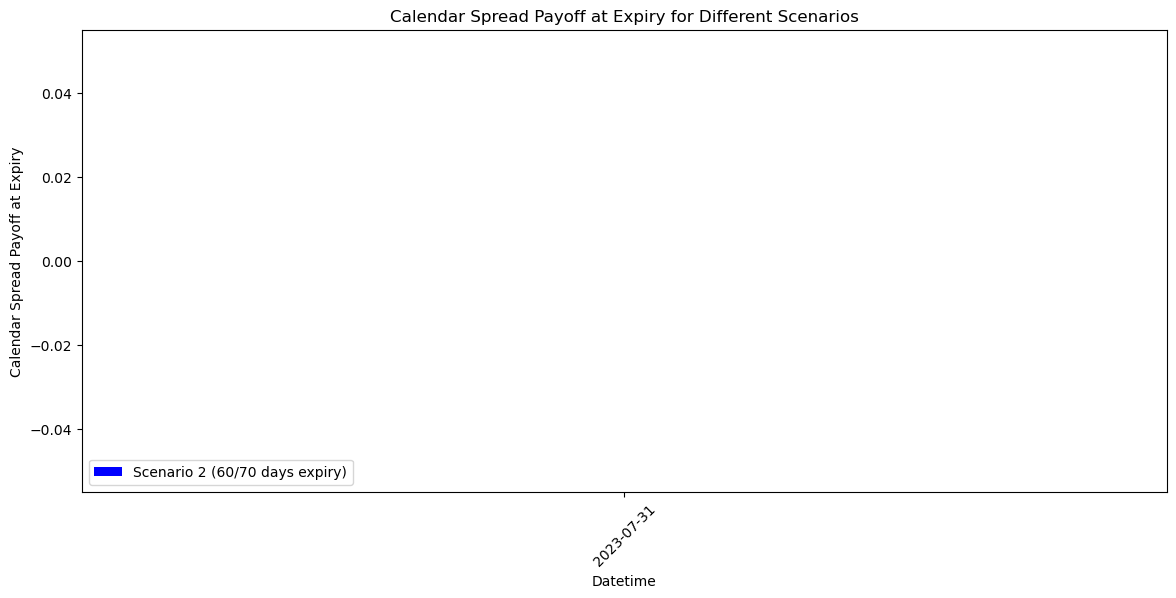

In [22]:
# Step 4: Visualize the Payoff
plt.figure(figsize=(14, 6))
plt.bar(scenario2['date'], scenario2['Calendar_Spread_Payoff'], label="Scenario 2 (60/70 days expiry)", color='blue')
# plt.bar(scenario2['date'], scenario2['Calendar_Spread_Payoff'], label="Scenario 2 (0/1 days expiry)", color='orange')
plt.xlabel('Datetime')
plt.ylabel('Calendar Spread Payoff at Expiry')
plt.title('Calendar Spread Payoff at Expiry for Different Scenarios')
plt.legend()
plt.xticks(rotation=45)
plt.show()